In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# if you've lost the associated utils file for this lecture, use the code in Appendix A, below
from utils import evaluate_and_plot

# Modeling Non-linear Relationships

Notebook by Joseph E. Gonzalez, Alvin Wan

In this notebook, we will use basic feature transformations (feature engineering) to model non-linear relationships using linear models.

**What does it mean to be a _Linear Model_?**

Linear models are **linear combinations** of features.  These models are therefore linear in the **parameters** but not necessarily the underlying data.  We can encode non-linearity in our data through the use of feature functions:


$$
f_\theta\left( x \right) = \phi(x)^T \theta = \sum_{j=0}^{p} \phi(x)_j \theta_j
$$

where $\phi$ is an *arbitrary function* from $x\in \mathbb{R}^d$ to $\phi(x) \in \mathbb{R}^{p+1}$. We could also denote these as a collection of separate feature $\phi_j$ feature functions from $x\in \mathbb{R}^d$ to $\phi_j(x) \in \mathbb{R}$:

$$
\phi(x) = \left[\phi_0(x), \phi_1(x), \ldots, \phi_p(x) \right]
$$


We often refer to these $\phi_j$ as **feature functions** and their design plays a critical role in both how we capture prior knowledge and our ability to fit complicated data

# 1. Load Uber Movement Speeds Dataset

To enable easy visualization of the model fitting process we will use a simple traffic speeds dataset, provided by Uber at https://movement.uber.com/cities/san_francisco/downloads/speeds?lang=en-US

In [3]:
df = pd.read_csv("data/movement-speeds-hourly-mar1to8-rand10ways-san-francisco-2020-3.csv") # load dataset
df['time'] = (df['day'] - 1) * 24 + df['hour'] # compute absolute time reference
df.head()

,day,hour,osm_way_id,speed_mph_mean,speed_mph_stddev,Latitude,Longitude,time
0,4,11,515486318,10.127,8.503,37.779522,-122.406901,83
1,1,12,515486318,11.217,9.453,37.779522,-122.406901,12
2,2,23,515486318,12.924,11.087,37.779522,-122.406901,47
3,1,0,515486318,13.827,9.969,37.779522,-122.406901,0
4,5,1,515486318,14.770,12.378,37.779522,-122.406901,97


# 2. Fit Biased OLS Model

We'll expand the data features we're allowed to use. Instead of just taking in time, our OLS model will now take in time and location.

In [1]:
from sklearn.linear_model import LinearRegression

In [4]:
X, Y = df[['Latitude', 'Longitude', 'time']], df[["speed_mph_mean"]] # extract data, labels

In [5]:
model = LinearRegression(fit_intercept=True)
model.fit(X, Y)
df['Yhat'] = model.predict(X)

Mean Squared Error: 166.65038016412558
Mean Absolute Error: 9.005150471839347
Root Mean Squared Error: 12.909313698416565


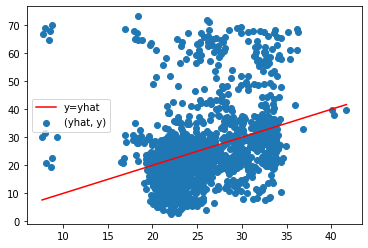

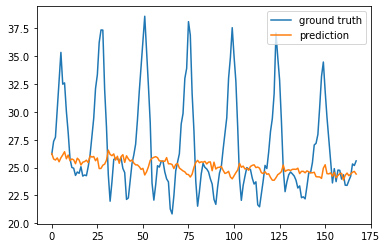

In [6]:
evaluate_and_plot(df, x='time', y='speed_mph_mean', yhat='Yhat')

Let's see our results so far.


||MSE|MAE|RMSE|
|---|---|---|---|
|**OLS**|346|14.0|18.6|
|**Biased OLS**|187|9.9|13.7|
|**Biased OLS + Location**|167|9.0|12.9|

Examining the above data we see that there is some **periodic** structure as well as some **curvature**. Can we fit this data with a linear model?

# 3. Polynomial Features

There is some curvature.  We can introduce polynomial terms to try to improve the fit of our model.

In [7]:
def phi_curved(X):
    return np.hstack([
        X,
        X * X,
        np.expand_dims(np.prod(X, axis=1), 1),
        X ** 3,
    ])

Can you guess the new number of features?

In [8]:
curvedX = phi_curved(X)
curvedX.shape

(154845, 10)

In [9]:
curved = LinearRegression()
curved.fit(curvedX, Y)
df['Yhat_curved'] = curved.predict(curvedX)

Mean Squared Error: 140.58983670108566
Mean Absolute Error: 8.535959311544053
Root Mean Squared Error: 11.857058518076297


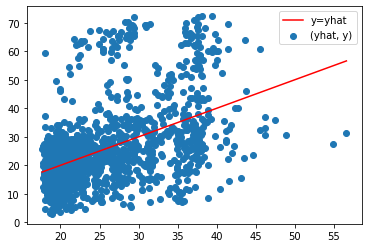

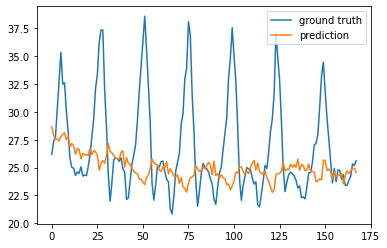

In [11]:
evaluate_and_plot(df, x='time', y='speed_mph_mean', yhat='Yhat_curved')

Looking at our results so far, we see that higher-order polynomial terms actually improved our best error by 16%.

||MSE|MAE|RMSE|
|---|---|---|---|
|**OLS**|346|14.0|18.6|
|**Biased OLS**|187|9.9|13.7|
|**Biased OLS + Location**|167|9.0|12.9|
|**Biased OLS + Location + Poly**|141|8.5|11.9|

# 4. Sinusoidal Features

In the following, we will add a few different sine functions at different frequencies and offsets.

$$
\sin\left(2 \pi * \textbf{frequency}X + \textbf{phase}\right)
$$

Note that for this to remain a linear model, we cannot make the frequency or phase of the sine function a model parameter.  In fact, these are actually **hyperparameters** of the model that would need to be tuned using either domain knowledge or other search procedures. 

In [22]:
def phi_periodic(X):
    return np.hstack([
        X,
        np.sin(X),
        np.sin(0.26*X),
        np.sin(X - 6),
        np.sin(0.26 * X - 6),
    ]) 

In [13]:
phi_periodic(X).shape

(154845, 15)

Let's combine all the features we have so far.

In [14]:
def phi_curved_and_periodic(X):
    return np.hstack([phi_curved(X), phi_periodic(X)])

In [15]:
crazyX = phi_curved_and_periodic(X)
crazyX.shape

(154845, 25)

Notice that to make predictions I need to actually apply the $\Phi$ feature function to my data.

In [16]:
crazy = LinearRegression()
crazy.fit(crazyX, Y)
df['Yhat_crazy'] = crazy.predict(crazyX)

Mean Squared Error: 132.35273102776773
Mean Absolute Error: 8.287970593274824
Root Mean Squared Error: 11.504465699360736


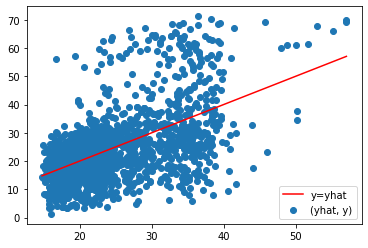

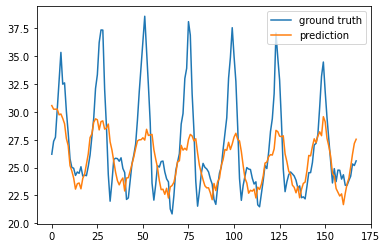

In [18]:
evaluate_and_plot(df, x='time', y='speed_mph_mean', yhat='Yhat_crazy')

Looking at our final table of results, our sinusoidal features improved our best error by 6%. Compared with our original OLS result, we've improved our error by 62%, reducing from 346 MSE by over 2x to 132 MSE.

||MSE|MAE|RMSE|
|---|---|---|---|
|**OLS**|346|14.0|18.6|
|**Biased OLS**|187|9.9|13.7|
|**Biased OLS + Location**|167|9.0|12.9|
|**Biased OLS + Location + Poly**|141|8.5|11.9|
|**Biased OLS + Location + Poly + Sin**|132|8.3|11.5|

## Success!

Using non-linear feature functions, we're now able to model non-linear relationships.

# Appendix A

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_y_vs_yhat(df, y, yhat):
    plt.figure()
    Y, Yhat = df[y], df[yhat]
    plt.scatter(Yhat, Y, label='(yhat, y)')
    cmin, cmax = max(Yhat.min(), Y.min()), min(Yhat.max(), Y.max())
    plt.plot([cmin, cmax], [cmin, cmax], color='red', label='y=yhat')
    plt.legend()

def plot_predictions(df, x, y, yhat):
    plt.figure()
    X, Y, Yhat = df[x], df[y], df[yhat]
    plt.plot(X, Y, label='ground truth')
    plt.plot(X, Yhat, label='prediction')
    plt.legend()

def plot_predictions_over_time(df, x, y, yhat):
    time = df.groupby(by='time').agg('mean').reset_index()
    plot_predictions(time, x, y, yhat)

def evaluate(df, y, yhat):
    """Compute and print error metrics"""
    Y, Yhat = df[y], df[yhat]
    metrics = {
        'MSE': mean_squared_error(Y, Yhat),
        'MAE': mean_absolute_error(Y, Yhat),
        'RMSE': np.sqrt(mean_squared_error(Y, Yhat)),
    }
    print("Mean Squared Error:", metrics['MSE'])
    print("Mean Absolute Error:", metrics['MAE'])
    print("Root Mean Squared Error:", metrics['RMSE'])
    return metrics

def evaluate_and_plot(df, x, y, yhat):
    """Report error metrics and also visualize"""
    evaluate(df, y, yhat)
    plot_y_vs_yhat(df.sample(frac=0.01), y, yhat)
    plot_predictions_over_time(df, x, y, yhat)

# Appendix B

**Practice: Repeating this on Toy Dataset**

Let's consider a toy example, where all of your samples lie along a parabola.

$$y = x^2$$

Now, add $\sigma$, where $\sigma$ is noise distributed uniformly between 0 and 1.

$$y = x^2 + \sigma$$

In [ ]:
# create toy dataset
x = np.random.random((100,)) * 10
y = x ** 2

# add noise
sigma = np.random.random((100,)) * 10
y = y + sigma

In [ ]:
# plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='markers'))

In [ ]:
toy = LinearRegression(fit_intercept=True)
toy.fit(x[:, None], y[:, None])
yhat = toy.predict(x[:, None])

In [ ]:
print("Mean Squared Error:", mean_squared_error(y, yhat))
print("Mean Absolute Error:", mean_absolute_error(y, yhat))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y, yhat)))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='markers'))
fig.add_trace(go.Scatter(x=x, y=yhat[:, 0]))

There is still some curvature.  We can introduce additional polynomial terms to try to improve the fit of our model.

In [ ]:
def phi_curved(X):
    return np.hstack([
        X,
        X ** 2,
    ])

Can you guess the new number of features?

In [ ]:
phi_curved(x[:, None]).shape

In [ ]:
crazy_model = LinearRegression()
crazy_model.fit(phi_curved_and_periodic(x[:, None]), y[:, None])
crazy_model.coef_

In [ ]:
yhat2 = crazy_model.predict(phi_curved_and_periodic(x[:, None]))
print("Mean Squared Error:", mean_squared_error(y, yhat2))
print("Mean Absolute Error:", mean_absolute_error(y, yhat2))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y, yhat2)))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='markers'))
fig.add_trace(go.Scatter(x=x, y=yhat2[:, 0], mode='markers'))